In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
plt.style.use('bmh')

In [2]:
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']
X_train = np.load('flower_species_classification/data_train.npy').T
t_train = np.load('flower_species_classification/labels_train.npy')

print(X_train.shape, t_train.shape)

(1658, 270000) (1658,)


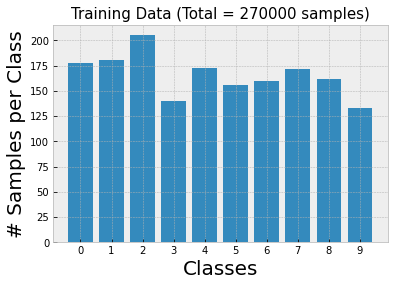

In [3]:
vals, counts = np.unique(t_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(X_train.shape[1])+' samples)',size=15);

In [4]:
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.2, stratify=t_train, shuffle=True)

In [5]:
X_train_rs = tf.constant(X_train.reshape((X_train.shape[0],300,300,3))/255, dtype=tf.float32)
X_val_rs = tf.constant(X_val.reshape((X_val.shape[0],300,300,3))/255, dtype=tf.float32)

2024-12-04 18:20:43.373350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 18:20:44.746806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-12-04 18:20:44.748503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78902 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


In [6]:
def build_model(hp):
    model = models.Sequential()
    
    # Single Convolutional Layer with hyperparameters
    model.add(layers.Conv2D(
        filters=hp.Choice('filters', values=[32, 64]),  # Corrected hyperparameter name
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),  # Corrected hyperparameter name
        activation='relu',
        input_shape=(300, 300, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Single Dense Layer with hyperparameters
    model.add(layers.Dense(
        units=hp.Choice('dense_units', values=[128, 256]),  # Corrected hyperparameter name
        activation='relu'
    ))

    model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])  # Corrected hyperparameter name
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [7]:
# Set up Keras Tuner for the simplified model
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter configurations to try
    executions_per_trial=1,
    directory='flower_tuning',
    project_name='flower_species'
)

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# Perform the hyperparameter search
tuner.search(
    X_train_rs, t_train,
    epochs=10,
    validation_data=(X_val_rs, t_val),
    callbacks=[stop_early]
)

# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
filters for convolutional layer: {best_hps.get('filters')}
kernel size for convolutional layer: {best_hps.get('kernel_size')}
dense units: {best_hps.get('dense_units')}
learning rate: {best_hps.get('learning_rate')}
""")


INFO:tensorflow:Reloading Oracle from existing project flower_tuning/flower_species/oracle.json
INFO:tensorflow:Reloading Tuner from flower_tuning/flower_species/tuner0.json
INFO:tensorflow:Oracle triggered exit

filters for convolutional layer: 64
kernel size for convolutional layer: 3
dense units: 256
learning rate: 0.0001



In [8]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_rs, t_train,
    epochs=20,
    validation_data=(X_val_rs, t_val),
    callbacks=[stop_early]
)

train_loss, train_accuracy = best_model.evaluate(X_train_rs, t_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

val_loss, val_accuracy = best_model.evaluate(X_val_rs, t_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Epoch 1/20


2024-12-04 18:20:48.355343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-12-04 18:20:49.872234: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 4s 38ms/step - loss: 5.0816 - accuracy: 0.2677 - val_loss: 1.6488 - val_accuracy: 0.4127
Epoch 2/20
42/42 [==============================] - 1s 31ms/step - loss: 1.3403 - accuracy: 0.5302 - val_loss: 1.2853 - val_accuracy: 0.5572
Epoch 3/20
42/42 [==============================] - 1s 31ms/step - loss: 0.8351 - accuracy: 0.7504 - val_loss: 1.0651 - val_accuracy: 0.6446
Epoch 4/20
42/42 [==============================] - 1s 31ms/step - loss: 0.4675 - accuracy: 0.8801 - val_loss: 0.8961 - val_accuracy: 0.6777
Epoch 5/20
42/42 [==============================] - 1s 32ms/step - loss: 0.2347 - accuracy: 0.9630 - val_loss: 0.8846 - val_accuracy: 0.6777
Epoch 6/20
42/42 [==============================] - 1s 30ms/step - loss: 0.1289 - accuracy: 0.9887 - val_loss: 0.8197 - val_accuracy: 0.7199
Epoch 7/20
42/42 [==============================] - 1s 30ms/step - loss: 0.0727 - accuracy: 0.9992 - val_loss: 0.8094 - val_accuracy: 0.7108
Epoch 8/20
42/42 [======

In [9]:
train_predictions = tf.argmax(best_model.predict(X_train_rs), axis=1).numpy()
val_predictions = tf.argmax(best_model.predict(X_val_rs), axis=1).numpy()

print("\nClassification Report on Training Data:")
print(classification_report(t_train, train_predictions, target_names=class_names))

print("\nClassification Report on Validation Data:")
print(classification_report(t_val, val_predictions, target_names=class_names))


Classification Report on Training Data:
               precision    recall  f1-score   support

        Roses       1.00      1.00      1.00       141
    Magnolias       1.00      1.00      1.00       144
       Lilies       1.00      1.00      1.00       164
   Sunflowers       1.00      1.00      1.00       112
      Orchids       1.00      1.00      1.00       138
     Marigold       1.00      1.00      1.00       125
     Hibiscus       1.00      1.00      1.00       128
     Firebush       1.00      1.00      1.00       138
       Pentas       1.00      1.00      1.00       130
Bougainvillea       1.00      1.00      1.00       106

     accuracy                           1.00      1326
    macro avg       1.00      1.00      1.00      1326
 weighted avg       1.00      1.00      1.00      1326


Classification Report on Validation Data:
               precision    recall  f1-score   support

        Roses       0.69      0.56      0.62        36
    Magnolias       0.76      0.

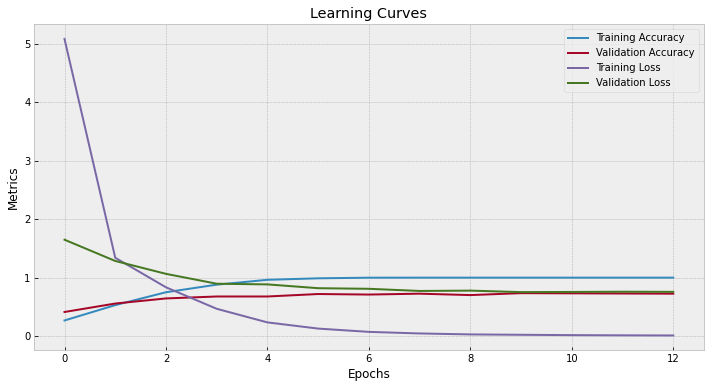

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

In [11]:
best_model.save('best_model.keras')